# 1. Загрузка библиотек и объявление путей

In [6]:
import os
import glob
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import json
from pprint import pprint
import shutil
import yaml
from ultralytics import YOLO

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Пути до датасетов с автомобилями
PATH_CAR = './DATASET/CarDetection' # Путь до датасета Car Detection
PATH_CARS = './DATASET/CarsDetection/Cars Detection/' # Путь до датасета Cars Detection
PATH_CAR_PERSON = './DATASET/CarPerson/Car-Person-v2-Roboflow-Owais-Ahmad/' # Путь до датасета Car Person

# Пути до датасетов с ЛЭП
PATH_STN = './DATASET/STN' # Путь до датасета STN PLAD
PATH_UTILLUTY_POLE = './DATASET/UtilityPole/' # Путь до датасета Utiluty Pole
PATH_TRANSMISSION = './DATASET/Transmission/data_original_size_v1/data_original_size/' # Путь до датасета Transmission

# Пути до датасетов с деревьями
PATH_TREE = './DATASET/Tree/' # Путь до датасета Tree Detection
PATH_TREE_DETECTION = './DATASET/TreeDetection/' # Путь до датасета Tree Detection
PATH_TREE_100 = './DATASET/Trees100/' # Путь до датасета Tree 100

# Пути до датасетов с птицами
PATH_BIRD_ANNOTATION = './DATASET/BirdAnnotation/' # Путь до датасета Bird Annotation 
PATH_BIRDS_DETECTOR = './DATASET/BirdsDetector/' # Путь до датасета Birds Detector
PATH_BIRDS_V3 = './DATASET/BirdsV3/' # Путь до датасета BirdsV3

# Пути до датасетов со зданиями
PATH_BUILDING_DETECTION = './DATASET/BuildingDetection/' # Путь до датасета Building Detection
PATH_JOSH_EDITS = './DATASET/JoshEdits/' # Путь до датасета JoshEdits

# 2. Обработка данных

In [8]:
def converterYoloToDataFrame(labels_list, path, classes):
    '''
        Функция позволяет перенести все данные с формата YOLO в DataFrame
        Input:
            labels_list - набор названий изображений
            path - путь до папки с изображениями
    '''
    labels = {} # Словарь объктов
    number_item = 0 # Номер записи
    for item in tqdm(labels_list):
        # Читаем все записи
        with open(path + item) as f:
            lines = f.readlines()
    
        # Проходимся по каждой записи
        for line in lines:
            # Получаем координаты в процентах
            x_center, y_center, w, h = (float(number) for number in line.split()[1:]) 
    
            # Заносим в словарь
            labels[number_item] = {
                'image_name': '/'.join(path.split('/')[:-2]) + '/images/' + item[:-3] + 'jpg',
                'x_center': x_center, 
                'y_center': y_center, 
                'w': w, 
                'h': h,
                'classes': classes
            }
            number_item += 1
    return labels

## 2.0 Классы для модели
    0 - машина
    1 - ЛЭП
    2 - Деревья
    3 - Птицы
    4 - Дом/здание
    5 - Провода

## 2.1. Датасеты с автомобилями
### 2.1.1 Обработка датасета Car Detection

In [9]:
img_h, img_w = (380, 676) # Размеры изображения
df = pd.read_csv(PATH_CAR + '/train_solution_bounding_boxes (1).csv') # Читаем датасет

df.rename(columns={'image':'image_name'}, inplace=True) # Переименовываем колонку

df.sample(10) # посмотрим на данные

,image_name,xmin,ymin,xmax,ymax
428,vid_4_6240.jpg,178.538350,196.816281,270.986975,227.627091
188,vid_4_1880.jpg,161.907381,194.370978,345.337193,267.240991
178,vid_4_1820.jpg,540.995658,164.049228,676.000000,245.722330
470,vid_4_700.jpg,586.486252,181.166345,676.000000,248.167632
100,vid_4_13860.jpg,609.476122,173.616474,676.000000,216.378700
388,vid_4_30020.jpg,394.740955,180.188224,491.102750,218.334942
492,vid_4_8960.jpg,7.385288,192.414994,133.427531,237.207740
225,vid_4_2040.jpg,0.000000,205.619369,35.218524,233.984878
43,vid_4_12180.jpg,482.787265,174.808559,518.984081,204.641248
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575


In [10]:
# Получим координаты центра объекта в процентах 
df['x_center'] = (df['xmin'] + df['xmax']) / 2 / img_w 
df['y_center'] = (df['ymin'] + df['ymax']) / 2 / img_h 

# Получим размеры объекта в процентах
df['w'] = (df['xmax'] - df['xmin']) / img_w # Получаем ширину объекта в процентах
df['h'] = (df['ymax'] - df['ymin']) / img_h # Получаем ширину объекта в процентах
df['classes'] = 0 # Задаём класс объекта
df.drop(
    ['xmin', 'xmax', 'ymin', 'ymax'], # Удаляем ненужные признаки
    axis=1, inplace=True
)

# Изменим путь до файла
df['image_name'] = f'{PATH_CAR}/training_images/' + df['image_name']

# Очистим память 
del img_h, img_w 

df.sample(10) # Посмотрим на данные

,image_name,x_center,y_center,w,h,classes
22,./DATASET/CarDetection/training_images/vid_4_1...,0.562952,0.561052,0.146165,0.109395,0
114,./DATASET/CarDetection/training_images/vid_4_1...,0.065485,0.553974,0.130970,0.097812,0
197,./DATASET/CarDetection/training_images/vid_4_1...,0.893271,0.534669,0.164255,0.128700,0
27,./DATASET/CarDetection/training_images/vid_4_1...,0.685239,0.552043,0.156295,0.083655,0
503,./DATASET/CarDetection/training_images/vid_4_9...,0.898762,0.517366,0.202476,0.172280,0
461,./DATASET/CarDetection/training_images/vid_4_6...,0.845876,0.514077,0.111433,0.087516,0
403,./DATASET/CarDetection/training_images/vid_4_3...,0.477207,0.573922,0.272793,0.176319,0
224,./DATASET/CarDetection/training_images/vid_4_2...,0.216353,0.574566,0.134588,0.084942,0
539,./DATASET/CarDetection/training_images/vid_4_9...,0.431901,0.554283,0.142753,0.101036,0
208,./DATASET/CarDetection/training_images/vid_4_1...,0.955499,0.514720,0.083213,0.106821,0


## 2.1.2. Обработка датасета Cars Detection

In [11]:
dataCarsDetection = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_CARS}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_CARS}{sample}/labels/', 0)) # Получаем датасет с разметкой
    dataCarsDetection = pd.concat([dataCarsDetection, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataCarsDetection.sample(10)# Посмотрим на данные

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
153,./DATASET/CarsDetection/Cars Detection/test/im...,0.91226,0.423077,0.082933,0.137019,0
426,./DATASET/CarsDetection/Cars Detection/valid/i...,0.920673,0.509615,0.147837,0.25601,0
1177,./DATASET/CarsDetection/Cars Detection/train/i...,0.413462,0.09976,0.141827,0.127404,0
1314,./DATASET/CarsDetection/Cars Detection/train/i...,0.620192,0.508413,0.084135,0.040865,0
93,./DATASET/CarsDetection/Cars Detection/train/i...,0.848558,0.151442,0.164663,0.129808,0
337,./DATASET/CarsDetection/Cars Detection/valid/i...,0.939904,0.842548,0.116587,0.282452,0
387,./DATASET/CarsDetection/Cars Detection/train/i...,0.18149,0.144231,0.169471,0.216346,0
365,./DATASET/CarsDetection/Cars Detection/valid/i...,0.915865,0.277644,0.016827,0.019231,0
171,./DATASET/CarsDetection/Cars Detection/train/i...,0.320913,0.519231,0.076923,0.048077,0
703,./DATASET/CarsDetection/Cars Detection/train/i...,0.153846,0.417067,0.078125,0.072115,0


### 2.1.3. Обработка датасета Car Person

In [12]:
dataCarPerson = pd.DataFrame(columns=df.columns)
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_CAR_PERSON}{sample}/labels') # Список файлов с разметкой
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_CAR_PERSON}{sample}/labels/', 0)) # Получаем датасет с разметкой
    dataCarPerson = pd.concat([dataCarPerson, labels.T]) # Соединяем выборки в единый датасет
    
del labels_name, labels # Очищаем память
dataCarPerson.sample(10) # Посмотрим на данные

  0%|          | 0/1571 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
7147,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.527644,0.760817,0.004808,0.014423,0
1217,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.496394,0.366587,0.292067,0.733173,0
5242,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.266827,0.0625,0.084135,0.054087,0
9468,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.682692,0.353365,0.038462,0.324519,0
11293,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.246394,0.786058,0.026442,0.123798,0
530,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.479567,0.55649,0.146635,0.515625,0
6712,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.247596,0.612981,0.084135,0.326923,0
2751,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.484375,0.907452,0.09375,0.182692,0
907,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.430288,0.846154,0.15024,0.143029,0
2397,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.236779,0.669471,0.021635,0.067308,0


## 2.2. Обработка датасет с ЛЭП
### 2.2.1 Обработка датасета STN_PLAD

In [13]:
# Читаем файл с разметкой датасета STN
with open(PATH_STN + '/annotations.json') as f:
    dataSTN = json.load(f)

pprint(dataSTN['categories']) # Посмотрим на категории

# Получим два DataFrame, один с изображениями, другой с разметкой объектов
data = pd.DataFrame(dataSTN['images']).rename(columns={'id': 'image_id'})
data1 =  pd.DataFrame(dataSTN['annotations'])

# Объединим два дасатсета и удалим лишние признаки
dataSTN = pd.merge(data, data1, on='image_id', how='left').drop(
    [
        'licence', 'segmentation', 'date_captured', 'coco_url', 
        'iscrowd', 'image_id'
    ], axis=1
)

# Очистим память 
del data, data1 

dataSTN.sample(10) # Посмотрим на данные

[{'id': 0, 'name': 'tower', 'supercategory': 'tower'},
 {'id': 1, 'name': 'insulator', 'supercategory': 'component'},
 {'id': 2, 'name': 'spacer', 'supercategory': 'component'},
 {'id': 3, 'name': 'damper', 'supercategory': 'component'},
 {'id': 5, 'name': 'plate', 'supercategory': 'component'}]


,file_name,height,width,flickr_url,area,bbox,category_id,id
718,20181127-A1/DJI_0493.JPG,3078,5472,,8442,"[1685, 2135, 126, 67]",5,721
2166,20181129-R/DJI_0013.JPG,3648,5472,,4956084,"[2750, 666, 1662, 2982]",0,2179
1583,20181127-A1/DJI_0486.JPG,3078,5472,,27450,"[1010, 209, 122, 225]",0,1590
347,20181127-A1/DJI_0440.JPG,3078,5472,,6215,"[2969, 2456, 113, 55]",3,348
671,20181127-A1/DJI_0475.JPG,3078,5472,,646,"[1778, 1687, 17, 38]",3,674
1633,20181127-A1/DJI_0444.JPG,3078,5472,,2970,"[2620, 1960, 54, 55]",3,1641
1130,20181127-A1/DJI_0509.JPG,3078,5472,,9918,"[2227, 2067, 114, 87]",3,1136
1607,20181129-R/DJI_0012.JPG,3648,5472,,1540,"[2655, 2089, 77, 20]",3,1614
701,20181127-A1/DJI_0483.JPG,3078,5472,,4200,"[1115, 2348, 50, 84]",3,704
1354,20181127-A1/DJI_0497.JPG,3078,5472,,1144,"[3997, 1782, 26, 44]",3,1361


In [14]:
# Получим координаты объекта
dataSTN[['xmin', 'ymin', 'xmax', 'ymax']] = dataSTN['bbox'].apply(lambda x: pd.Series(x))
dataSTN['xmax'] = dataSTN['xmax'] + dataSTN['xmin']
dataSTN['ymax'] = dataSTN['ymax'] + dataSTN['ymin']

# Получим координаты центра объекта в процентах 
dataSTN['x_center'] = (dataSTN['xmin'] + dataSTN['xmax']) / 2 / dataSTN['width']
dataSTN['y_center'] = (dataSTN['ymin'] + dataSTN['ymax']) / 2 / dataSTN['height']

# Получим размеры объекта в процентах
dataSTN['w'] = (dataSTN['xmax'] - dataSTN['xmin']) / dataSTN['width']
dataSTN['h'] = (dataSTN['ymax'] - dataSTN['ymin']) / dataSTN['height']

# Переименуем признаки
dataSTN.rename(
    columns={
        'file_name': 'image_name',
        'category_id': 'classes'
    }, 
    inplace=True
) 

# Удалим ненужные признаки
dataSTN.drop(
    [
        'height', 'width', 'flickr_url',
        'area', 'bbox', 'id', 'xmin', 
        'xmax', 'ymin', 'ymax'
    ], 
    axis=1, inplace=True
)

# Изменим путь до файла
dataSTN['image_name'] = './DATASET/STN/' + dataSTN['image_name']

# Оставим фотографии принадлижащие только к опоре ЛЭП
dataSTN = dataSTN[dataSTN['classes'] == 0]
dataSTN['classes'] = dataSTN['classes'] + 1

dataSTN.sample(10) # Посомтрим на данные

,image_name,classes,x_center,y_center,w,h
464,./DATASET/STN/20181127-A1/DJI_0459.JPG,1,0.362573,0.544834,0.043129,0.587394
1290,./DATASET/STN/20181127-A1/DJI_0451.JPG,1,0.745066,0.634016,0.509868,0.731969
126,./DATASET/STN/20181127-A1/DJI_0488.JPG,1,0.109740,0.094379,0.032712,0.089344
939,./DATASET/STN/20181129-R/DJI_0019.JPG,1,0.430373,0.541393,0.333699,0.917215
1965,./DATASET/STN/20181129-R/DJI_0004.JPG,1,0.870523,0.185855,0.023209,0.093202
440,./DATASET/STN/20181129-R/DJI_0020.JPG,1,0.123721,0.415707,0.016447,0.083059
933,./DATASET/STN/20181127-A1/DJI_0431.JPG,1,0.505391,0.700942,0.080227,0.598116
2240,./DATASET/STN/20181127-A1/DJI_0516.JPG,1,0.678728,0.500162,0.393275,0.999675
1246,./DATASET/STN/20181129-R/DJI_0003.JPG,1,0.516539,0.554550,0.729715,0.890899
39,./DATASET/STN/20181129-R/DJI_0024.JPG,1,0.505757,0.501371,0.958151,0.997259


### 2.2.2. Обработка датасета Utility Pole

In [15]:
dataUnilityPole = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'test']:
    labels_name = os.listdir(f'{PATH_UTILLUTY_POLE}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_UTILLUTY_POLE}{sample}/labels/', 1)) # Получаем датасет с разметкой
    dataUnilityPole = pd.concat([dataUnilityPole, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataUnilityPole.sample(10) # Посмотрим на данные

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
240,./DATASET/UtilityPole/train/images/pennwell-we...,0.260817,0.518029,0.151442,0.824519,1
192,./DATASET/UtilityPole/train/images/a93a35ee792...,0.549279,0.453125,0.28125,0.757212,1
248,./DATASET/UtilityPole/train/images/lumwoodup_j...,0.608173,0.614183,0.394231,0.766827,1
271,./DATASET/UtilityPole/train/images/images_jpg....,0.117788,0.520433,0.105769,0.521635,1
131,./DATASET/UtilityPole/train/images/Pole-standi...,0.503606,0.524038,0.252404,0.817308,1
133,./DATASET/UtilityPole/train/images/images--7-_...,0.454327,0.501202,0.254808,0.949519,1
249,./DATASET/UtilityPole/train/images/lumwoodup_j...,0.079327,0.730769,0.153846,0.533654,1
87,./DATASET/UtilityPole/train/images/lumwoodup_j...,0.391827,0.614183,0.394231,0.766827,1
209,./DATASET/UtilityPole/train/images/5fa1d4a1856...,0.817308,0.53726,0.254808,0.915865,1
238,./DATASET/UtilityPole/train/images/french76_jp...,0.722356,0.454327,0.151442,0.822115,1


### 2.2.3. Обработка датасета Transmission

In [16]:
list_image = glob.glob(PATH_TRANSMISSION + '*.jpg')
labels = {} # Словарь объктов
number_item = 0 # Номер записи
for path_image in tqdm(list_image):
    with open(path_image[:-3] + 'json') as f:
        json_file = json.load(f)
    xmax = 0
    xmin = 2**10
    ymax = 0
    ymin = 2**10
    h = json_file['imageHeight']
    w = json_file['imageWidth']
    for item in json_file['shapes']:
        if item['label'] in ['tower_wooden', 'cable']:
            for data in item['points']:
                x, y = data
                xmax = x if x > xmax else xmax
                ymax = y if x > ymax else ymax
                xmin = x if y < xmin else xmin
                ymin = y if y < ymin else ymin
            labels[number_item] = {
                'image_name': path_image,
                'x_center': (xmin + xmax) / 2 / w, 
                'y_center': (ymin + xmax) / 2 / h, 
                'w': (xmax - xmin) / w, 
                'h': (ymax - ymin) / h,
                'classes': 1 if item['label'] == 'tower_wooden' else 5
            }
            number_item += 1
            
dataTransmission = pd.DataFrame(labels).T # Переносим все в DataFrame

# Очищаем память
del list_image, labels, number_item, xmin, xmax, ymin, ymax, h, w, json_file 

dataTransmission.sample(10) # Посмотрим на данные

  0%|          | 0/1242 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
4602,./DATASET/Transmission/data_original_size_v1/d...,0.517854,0.470908,0.023614,0.0,1
3839,./DATASET/Transmission/data_original_size_v1/d...,0.517281,0.888657,0.964916,0.085594,5
5745,./DATASET/Transmission/data_original_size_v1/d...,0.392154,0.697261,0.784088,0.884154,5
9618,./DATASET/Transmission/data_original_size_v1/d...,0.483834,0.585661,0.350068,0.847501,5
2552,./DATASET/Transmission/data_original_size_v1/d...,0.658471,0.587651,0.005272,0.036639,5
1045,./DATASET/Transmission/data_original_size_v1/d...,0.683056,0.770989,0.369123,0.199656,5
279,./DATASET/Transmission/data_original_size_v1/d...,0.632845,1.125058,0.732357,0.298929,5
1397,./DATASET/Transmission/data_original_size_v1/d...,0.53618,0.889358,0.928695,0.249246,5
4524,./DATASET/Transmission/data_original_size_v1/d...,0.49987,1.052546,0.99974,0.401637,5
1950,./DATASET/Transmission/data_original_size_v1/d...,0.853646,0.758796,0.0,0.999537,5


## 2.3. Обработка датасетов с деревьями
### 2.3.1. Обработка датасета Tree Object Detecion

In [17]:
dataTree = pd.DataFrame(columns=df.columns)
labels_name = os.listdir(f'{PATH_TREE}train/labels/') # Список файлов с разметкой
labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_TREE}train/labels/', 2)) # Получаем датасет с разметкой
dataTree = pd.concat([dataTree, labels.T]) # Соединяем выборки в единый датасет
    
del labels_name, labels # Очищаем память
dataTree.sample(10) # Посмотрим на данные

  0%|          | 0/214 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
639,./DATASET/Tree/train/images/20230709_155610_jp...,0.171094,0.691406,0.329688,0.617188,2
390,./DATASET/Tree/train/images/images-38-_jpg.rf....,0.705469,0.796875,0.16875,0.201563,2
97,./DATASET/Tree/train/images/images-50-_jpg.rf....,0.484375,0.428906,0.690625,0.742188,2
565,./DATASET/Tree/train/images/images-46-_jpg.rf....,0.91875,0.494531,0.1625,0.721875,2
346,./DATASET/Tree/train/images/images-5-_jpg.rf.7...,0.536719,0.480469,0.451562,0.929688,2
562,./DATASET/Tree/train/images/images-22-_jpg.rf....,0.592969,0.445312,0.55,0.779687,2
338,./DATASET/Tree/train/images/sacramento_streett...,0.772656,0.388281,0.33125,0.465625,2
335,./DATASET/Tree/train/images/sacramento_streett...,0.363281,0.489063,0.726562,0.978125,2
53,./DATASET/Tree/train/images/The-Survivor-Tree-...,0.176563,0.476562,0.353125,0.70625,2
154,./DATASET/Tree/train/images/50612238_401_jpg.r...,0.086719,0.7375,0.104688,0.525,2


### 2.3.2. Обработка датасета TreeDetection 

In [18]:
dataTreeDetection = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_TREE_DETECTION}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_TREE_DETECTION}{sample}/labels/', 2)) # Получаем датасет с разметкой
    dataTreeDetection = pd.concat([dataTreeDetection, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataTreeDetection.sample(10) # Посмотрим на данные

  0%|          | 0/1803 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
3140,./DATASET/TreeDetection/train/images/221023_17...,0.410156,0.69375,0.81875,0.6125,2
1214,./DATASET/TreeDetection/train/images/c6e42352-...,0.497656,0.488281,0.951562,0.976562,2
1995,./DATASET/TreeDetection/train/images/231003_17...,0.415625,0.475781,0.672656,0.580469,2
708,./DATASET/TreeDetection/train/images/210926_16...,0.539844,0.5625,0.813281,0.782031,2
2697,./DATASET/TreeDetection/train/images/230924_18...,0.494531,0.548438,0.825781,0.834375,2
2100,./DATASET/TreeDetection/train/images/211007_17...,0.878125,0.582812,0.202344,0.5,2
2331,./DATASET/TreeDetection/train/images/875fa4eb-...,0.261719,0.632031,0.520312,0.735938,2
456,./DATASET/TreeDetection/train/images/0570f6ff-...,0.430469,0.604688,0.309375,0.146875,2
3219,./DATASET/TreeDetection/train/images/2588740f-...,0.514062,0.096094,0.245312,0.084375,2
2474,./DATASET/TreeDetection/train/images/5d77c012-...,0.210938,0.427344,0.264062,0.619531,2


### 2.3.3. Обработка датасета Tree 100

In [19]:
dataTree100 = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_TREE_100}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_TREE_100}{sample}/labels/', 2)) # Получаем датасет с разметкой
    dataTree100 = pd.concat([dataTree100, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataTree100.sample(10) # Посмотрим на данные

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
36,./DATASET/Trees100/valid/images/arvore61_jpg.r...,0.608594,0.494531,0.465625,0.721875,2
94,./DATASET/Trees100/train/images/arvore117_jpg....,0.492188,0.535937,0.633594,0.928125,2
90,./DATASET/Trees100/train/images/arvore63_jpg.r...,0.389844,0.714844,0.428125,0.570312,2
169,./DATASET/Trees100/train/images/arvore36_jpg.r...,0.610156,0.514062,0.708594,0.773438,2
168,./DATASET/Trees100/train/images/arvore69_jpg.r...,0.499219,0.488281,0.761719,0.700781,2
122,./DATASET/Trees100/train/images/arvore110_jpg....,0.90625,0.767969,0.18125,0.107031,2
19,./DATASET/Trees100/valid/images/arvore27_jpg.r...,0.516406,0.488281,0.626563,0.700781,2
18,./DATASET/Trees100/valid/images/arvore107_jpg....,0.622656,0.382031,0.257031,0.369531,2
28,./DATASET/Trees100/train/images/arvore03_jpg.r...,0.932813,0.164844,0.028906,0.076563,2
68,./DATASET/Trees100/train/images/arvore108_jpg....,0.51875,0.444531,0.864062,0.832031,2


## 2.4. Обработка датасета с птицами
### 2.4.1. Обработка датасета с Bird Annotation

In [20]:
dataBirdAnnotation = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_BIRD_ANNOTATION}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_BIRD_ANNOTATION}{sample}/labels/', 3)) # Получаем датасет с разметкой
    dataBirdAnnotation  = pd.concat([dataBirdAnnotation, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataBirdAnnotation.sample(10) # Посмотрим на данные

  0%|          | 0/1362 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
11856,./DATASET/BirdAnnotation/train/images/voladora...,0.920312,0.548438,0.040625,0.065625,3
1420,./DATASET/BirdAnnotation/valid/images/voladora...,0.803125,0.417969,0.0375,0.073438,3
12630,./DATASET/BirdAnnotation/train/images/voladora...,0.309375,0.617969,0.015625,0.035937,3
14886,./DATASET/BirdAnnotation/train/images/voladora...,0.974219,0.896094,0.048438,0.032813,3
1420,./DATASET/BirdAnnotation/train/images/voladora...,0.300781,0.476562,0.020313,0.029687,3
4954,./DATASET/BirdAnnotation/train/images/voladora...,0.914844,0.492969,0.026562,0.0375,3
8436,./DATASET/BirdAnnotation/train/images/descarga...,0.434375,0.489063,0.145313,0.15,3
2078,./DATASET/BirdAnnotation/train/images/descarga...,0.309375,0.442969,0.178125,0.215625,3
584,./DATASET/BirdAnnotation/valid/images/voladora...,0.978125,0.46875,0.040625,0.09375,3
373,./DATASET/BirdAnnotation/test/images/descarga-...,0.275,0.582031,0.034375,0.039062,3


### 2.4.2. Обработка датасета с Birds Detection

In [21]:
dataBirdsDetectod = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_BIRDS_DETECTOR}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_BIRDS_DETECTOR}{sample}/labels/', 3)) # Получаем датасет с разметкой
    dataBirdsDetectod = pd.concat([dataBirdsDetectod, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataBirdsDetectod.sample(10)  # Посмотрим на данные

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
130,./DATASET/BirdsDetector/valid/images/cuervo-se...,0.541406,0.567187,0.359375,0.489063,3
83,./DATASET/BirdsDetector/valid/images/voladoras...,0.65,0.046094,0.046875,0.092188,3
1169,./DATASET/BirdsDetector/valid/images/gg18_jpg....,0.342969,0.657813,0.023438,0.089063,3
763,./DATASET/BirdsDetector/test/images/jisus-16-_...,0.905469,0.5125,0.13125,0.283594,3
2041,./DATASET/BirdsDetector/train/images/e265_jpg....,0.434375,0.448437,0.488281,0.817187,3
747,./DATASET/BirdsDetector/train/images/-de-pajar...,0.478906,0.511719,0.058594,0.083594,3
644,./DATASET/BirdsDetector/train/images/voladoras...,0.745313,0.803125,0.06875,0.049219,3
1369,./DATASET/BirdsDetector/valid/images/e129_jpg....,0.836719,0.3375,0.042188,0.046094,3
306,./DATASET/BirdsDetector/test/images/voladorasc...,0.597656,0.891406,0.03125,0.053125,3
3094,./DATASET/BirdsDetector/train/images/e123_jpg....,0.495312,0.405469,0.063281,0.064062,3


### 2.4.3. Обработка датасета с BirdsV3

In [22]:
dataBirdsV3 = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_BIRDS_V3}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_BIRDS_V3}{sample}/labels/', 3)) # Получаем датасет с разметкой
    dataBirdsV3 = pd.concat([dataBirdsV3, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataBirdsV3.sample(10)  # Посмотрим на данные

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
134,./DATASET/BirdsV3/train/images/pigeons-on-an-o...,0.377344,0.53125,0.10625,0.1625,3
1774,./DATASET/BirdsV3/train/images/83ff5a3360c7b39...,0.314063,0.563281,0.05,0.042188,3
3574,./DATASET/BirdsV3/train/images/189734857_jpg.r...,0.511719,0.383594,0.145313,0.1125,3
4434,./DATASET/BirdsV3/train/images/birds-roof-clos...,0.585156,0.535156,0.090625,0.148438,3
3707,./DATASET/BirdsV3/train/images/4541968436_353e...,0.759375,0.434375,0.042188,0.039062,3
78,./DATASET/BirdsV3/train/images/birds_on_roof_t...,0.3125,0.592187,0.045312,0.051562,3
2930,./DATASET/BirdsV3/train/images/birds-roof-8390...,0.3125,0.689844,0.057813,0.085938,3
38,./DATASET/BirdsV3/valid/images/pigeons-on-the-...,0.719531,0.667969,0.022656,0.049219,3
3405,./DATASET/BirdsV3/train/images/383146643_jpg.r...,0.505469,0.614062,0.01875,0.021875,3
12,./DATASET/BirdsV3/valid/images/pigeons-on-the-...,0.564844,0.803906,0.05,0.05,3


## 2.5. Обработка фотографий со зданиями
### 2.5.1. Обработка датасета Building Detection 

In [23]:
dataBuildingDetection = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_BUILDING_DETECTION}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_BUILDING_DETECTION}{sample}/labels/', 4)) # Получаем датасет с разметкой
    dataBuildingDetection = pd.concat([dataBuildingDetection, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataBuildingDetection.sample(10)  # Посмотрим на данные

  0%|          | 0/726 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
2,./DATASET/BuildingDetection/valid/images/379_A...,0.441106,0.513221,0.882212,0.965144,4
15,./DATASET/BuildingDetection/train/images/228_A...,0.5,0.514423,1.0,0.966346,4
625,./DATASET/BuildingDetection/train/images/137_A...,0.498588,0.498798,0.997177,0.997596,4
99,./DATASET/BuildingDetection/train/images/7_A_j...,0.498798,0.498798,0.997596,0.997596,4
668,./DATASET/BuildingDetection/train/images/161_A...,0.49264,0.498798,0.985279,0.997596,4
421,./DATASET/BuildingDetection/train/images/307_A...,0.739183,0.495192,0.516827,0.990385,4
30,./DATASET/BuildingDetection/test/images/81_jpg...,0.498798,0.502404,0.997596,0.990385,4
766,./DATASET/BuildingDetection/train/images/222_A...,0.498798,0.5,0.997596,1.0,4
14,./DATASET/BuildingDetection/train/images/195_A...,0.498798,0.498798,0.997596,0.997596,4
24,./DATASET/BuildingDetection/train/images/358_A...,0.5,0.498798,1.0,0.997596,4


### 2.5.2. Обработка датасета Josh Edits 

In [24]:
dataJoshEdits = pd.DataFrame(columns=df.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_JOSH_EDITS}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_JOSH_EDITS}{sample}/labels/', 4)) # Получаем датасет с разметкой
    dataJoshEdits = pd.concat([dataJoshEdits, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataJoshEdits.sample(10)  # Посмотрим на данные

  0%|          | 0/3042 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
5589,./DATASET/JoshEdits/train/images/1-Antique-Hom...,0.5,0.5,1.0,1.0,4
5254,./DATASET/JoshEdits/train/images/streetview_80...,0.108594,0.566406,0.217188,0.139063,4
1429,./DATASET/JoshEdits/train/images/modeltrouble_...,0.492188,0.465625,0.484375,0.228125,4
3969,./DATASET/JoshEdits/train/images/debug_image_2...,0.823438,0.532813,0.332813,0.267188,4
4328,./DATASET/JoshEdits/train/images/image_39_png....,0.339844,0.319531,0.382812,0.639062,4
2322,./DATASET/JoshEdits/train/images/sv_42-3885120...,0.875781,0.521875,0.248438,0.221875,4
5138,./DATASET/JoshEdits/train/images/sv_42-1166375...,0.217969,0.499219,0.103906,0.071094,4
5312,./DATASET/JoshEdits/train/images/modelmid_38-1...,0.415625,0.440625,0.635938,0.585938,4
2963,./DATASET/JoshEdits/train/images/260723_e8390d...,0.342969,0.26875,0.385937,0.246875,4
5744,./DATASET/JoshEdits/train/images/sv_37-4171019...,0.6125,0.346875,0.775,0.590625,4


# 3. Объединение датасетов в единый датасет

In [25]:
data = pd.concat(
    [
        df, dataCarPerson, dataCarsDetection, # Авто
        dataSTN, dataUnilityPole, dataTransmission, # ЛЭП
        dataTree, dataTreeDetection, dataTree100, # Деревья
        dataBirdAnnotation, dataBirdsDetectod, dataBirdsV3, # Птицы
        dataBuildingDetection, dataJoshEdits # Здания
    ], 
    ignore_index=True
) # Объеденим датасеты в один единый

del df, dataCarPerson, dataCarsDetection # очищаем память от датасетов с Авто
del dataSTN, dataUnilityPole, dataTransmission # очищаем память от датасетов с ЛЭП
del dataTree, dataTreeDetection, dataTree100 # очищаем память от датасетов со Деревьями
del dataBirdAnnotation, dataBirdsDetectod, dataBirdsV3 # очищаем память от датасетов со Птицами
del dataBuildingDetection, dataJoshEdits # очищаем память от датасетов со Зданиями

data.sample(10) # Посмотрим на данные

,image_name,x_center,y_center,w,h,classes
18937,./DATASET/CarsDetection/Cars Detection/train/i...,0.746394,0.655048,0.485577,0.116587,0
27239,./DATASET/Transmission/data_original_size_v1/d...,0.436307,0.399209,0.025605,0.913253,5
2955,./DATASET/CarPerson/Car-Person-v2-Roboflow-Owa...,0.21274,0.669471,0.019231,0.067308,0
60567,./DATASET/BirdsDetector/train/images/e241_jpg....,0.061719,0.840625,0.047656,0.053125,3
75316,./DATASET/JoshEdits/train/images/debug_image_2...,0.473438,0.478125,0.592969,0.204687,4
28658,./DATASET/Transmission/data_original_size_v1/d...,0.499178,0.994475,0.998357,0.01822,5
69502,./DATASET/BuildingDetection/train/images/194_A...,0.519935,0.497117,0.955323,0.994234,4
26427,./DATASET/Transmission/data_original_size_v1/d...,0.499758,0.954416,0.999516,0.339209,5
36133,./DATASET/BirdAnnotation/train/images/voladora...,0.461719,0.696875,0.03125,0.034375,3
48101,./DATASET/BirdAnnotation/train/images/voladora...,0.671094,0.714063,0.042188,0.040625,3


In [26]:
data['image_name'].unique().shape # Количество фотографий

(14921,)

In [27]:
# Изменим тип данных координат с string на float
for column in data.columns[1:-1]:
    data[column] = data[column].astype(float)

data['classes'] = data['classes'].astype(int) # Изменим тип классов с string на int
data.info() # Посмотрим на сведение датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76303 entries, 0 to 76302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  76303 non-null  object 
 1   x_center    76303 non-null  float64
 2   y_center    76303 non-null  float64
 3   w           76303 non-null  float64
 4   h           76303 non-null  float64
 5   classes     76303 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.5+ MB


In [28]:
count_image = data['image_name'].unique().shape[0]
print(f'Датасет содержит {count_image} уникальных фотографий и {data.shape[0]} объектов')
del count_image # Очищаем память

Датасет содержит 14921 уникальных фотографий и 76303 объектов


    0 - машина
    1 - ЛЭП
    2 - Деревья
    3 - Птицы
    4 - Дом/здание
    5 - Провода

In [29]:
# Выведем в процентах количество уникальных изображений по классам
data.groupby('image_name')['classes'].head().value_counts().sort_index() /  data.groupby('image_name')['classes'].head().shape[0] * 100

classes
0    31.338319
1     1.879835
2    11.392470
3    23.816400
4    19.216091
5    12.356885
Name: count, dtype: float64

    0 - машина
    1 - ЛЭП
    2 - Деревья
    3 - Птицы
    4 - Дом/здание
    5 - Провода

In [30]:
# Распределение классов среди всех объектов
data['classes'].value_counts().sort_index() / data.shape[0] * 100

classes
0    25.849573
1     1.151986
2     6.124268
3    43.842313
4     9.827923
5    13.203937
Name: count, dtype: float64

In [31]:
# Разделим данные на выборки
train_name_file, test_name_file = train_test_split(data['image_name'].unique(), test_size=.30, random_state=42) 
valid_name_file, test_name_file = train_test_split(test_name_file, test_size=.33, random_state=42)

# Посмотрим на процентное отношение выборок 
pd.DataFrame([len(train_name_file), len(valid_name_file), len(test_name_file)], columns=['size']) / len(data['image_name'].unique()) * 100

,size
0,69.995309
1,20.099189
2,9.905502


In [32]:
train_df = data[data['image_name'].isin(train_name_file)] # Записи для тренировочных данных
valid_df = data[data['image_name'].isin(valid_name_file)] # Записи для валидационных данных
test_df = data[data['image_name'].isin(test_name_file)] # Записи для тестовых данных
del data, train_name_file, valid_name_file, test_name_file # Очистим память

In [33]:
!mkdir DATA # Создаём папку с исходным датасетов

!mkdir DATA/train # Создаём папку с тренировочной выборкой 
!mkdir DATA/valid # Создаём папку с валидационной выборкой 
!mkdir DATA/test # Создаём папку с тестовой выборкой 

!mkdir DATA/train/images # Создаём папку с изображениями для тренировочной выборки
!mkdir DATA/train/labels # Создаём папку с разметкой для тренировочной выборки
!mkdir DATA/valid/images # Создаём папку с изображениями для валидационной выборки
!mkdir DATA/valid/labels # Создаём папку с разметкой для валидационной выборки
!mkdir DATA/test/images # Создаём папку с изображениями для тестовой выборки
!mkdir DATA/test/labels # Создаём папку с разметкой для тестовой выборки

In [34]:
def copyFileDataSet(df, pathEnd):
    '''
        Функция позволяет скопировать фото в новую папку и под каждую из них создать txt файл с разметкой
        Input:
            df - DataFrame содержащий в себе следующиго типа:
                Признаки    Non-Null?  Тип
                image_name  non-null   object 
                x_center    non-null   float64
                y_center    non-null   float64
                w           non-null   float64
                h           non-null   float64
                classes     non-null   int64
            pathEnd - путь созданной папки, внутри которой созданы папки
                images и labels
    '''
    nameFiles = df['image_name'].unique() # Получаем список уникальных файлов

    # Запускаем цикл по все файлам
    for item in tqdm(nameFiles):

        # shutil.copy2(item, pathEnd+'/images') # Копируем данный файл в другую директорию/
        img = cv2.imread(item, cv2.IMREAD_UNCHANGED)
        h, w, _ = img.shape
        Flag = False
        while (w > 1280 and h > 720 ):
            w /= 1.5
            h /= 1.5
        img = cv2.resize(cv2.UMat(img), (int(w), int(h)), cv2.INTER_NEAREST)
        cv2.imwrite(pathEnd + '/images/' + item.split('/')[-1], img)
        
        dataList = list(df[df['image_name'] == item].values) # Получаем все объекты на фото
        labelsFile = open(pathEnd + '/labels/' + item.split('/')[-1][:-3] + 'txt', 'w+') # Создаём текстовый документ с разметкой
        isFirst = True # Флаг первой строки

        # Запускаем цикл по всем объектам на фото
        for data in dataList:

            # Получаем линию с данными 
            line = '' if isFirst else '\n'
            isFirst = False
            line += str(data[-1]) + ' ' + ' '.join(str(number) for number in data[1:-1]) 
            
            labelsFile.write(line) # Записываем в файл
        labelsFile.close() # Закрываем файл
        
copyFileDataSet(train_df, './DATA/train') # Формируем тренировочную выборку
copyFileDataSet(valid_df, './DATA/valid') # Формируем валидационную выборку
copyFileDataSet(test_df, './DATA/test') # Формируем тестовую выборку
del train_df, valid_df, test_df # Очищаем память

  0%|          | 0/10444 [00:00<?, ?it/s]

  0%|          | 0/2999 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

In [35]:
yolo_format=dict(
    path = '/home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA',
    train = '../train',
    val = '../valid',
    test = '../test',       
    nc = 6,
    names={
        0: 'Car',
        1: 'STN',
        2: 'Tree',
        3: 'Bird',
        4: 'House',
        5: 'Cable',
    }
)
             
with open('./DATA/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [31]:
epochTraning = 250 # Количество эпох обучения
pathYalm = "./DATA/yolo.yaml" # Путь до файла yalm
patience = 10 # Терпимость эпох для переобучения

In [32]:
model = YOLO('yolov8n.yaml').load('yolov8n.pt')
model.train(data=pathYalm, epochs=epochTraning, patience=patience)  

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.1.24 🚀 Python-3.10.13 torch-2.2.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3904MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=./DATA/yolo.yaml, epochs=250, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_

train: Scanning /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2

train: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/train/images/04_585.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1244      1.1262]
train: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/train/images/08_1725.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.074       1.074       1.074       1.074       1.074]
train: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/train/images/09_9180.jpg: ignoring corrupt image/label: negative label values [  -0.051042   -0.022396]
train: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/train/images/1000_00081.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/train/images/1000_00295.jpg: 8 duplicate labels removed
train: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/train/images/1000_00303.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/train/images/1

train: New cache created: /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/train/labels.cache


val: Scanning /home/k1rsn7/K1rsN7/Notebook/ВШЭ 202

val: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/valid/images/103_5565.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1157      1.1208      1.1208      1.0992]
val: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/valid/images/105_5430.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/valid/images/106_135.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0449      1.0449      1.0449      1.0449      1.0449      1.0449]
val: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/valid/images/106_1395.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/valid/images/114_180.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/valid/images/11_00090.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/valid/images/11_00098.jpg: ignoring corrupt ima

val: New cache created: /home/k1rsn7/K1rsN7/Notebook/ВШЭ 2024/DATA/valid/labels.cache
Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      3.61G      1.561      2.666      


OutOfMemoryError: CUDA out of memory. Tried to allocate 894.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 837.25 MiB is free. Including non-PyTorch memory, this process has 2.98 GiB memory in use. Of the allocated memory 2.53 GiB is allocated by PyTorch, and 192.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [37]:
def converterYOLOToCV2(h, w, box):
    """
    Функция позволяет преобразовать кординаты объекта для последующей корректной отрисовки их на изображении
    Input:
        box - координаты объекта в формате [X_center Y_center, width, height]
    Output:
        x_start - координата X верхнего левого угла 
        y_start - координата Y верхнего левого угла 
        x_end - координата X нижнего правого угла 
        y_end - координата Y нижнего правого угла 
    """  
    # Получаем в процентах координаты левого верхнего угла
    x_start, y_start = box[0] - box[2] / 2, box[1] - box[3] / 2 
    
    # Получаем в процентах координаты правого нижнего угла
    x_end, y_end = box[0] + box[2] / 2, box[1] + box[3] / 2  
    
    # Конвертируем координаты из процентов в пиксели 
    x_start = int(x_start * w) 
    y_start = int(y_start * h)
    x_end = int(x_end * w)
    y_end = int(y_end * h)

    return x_start, y_start, x_end, y_end

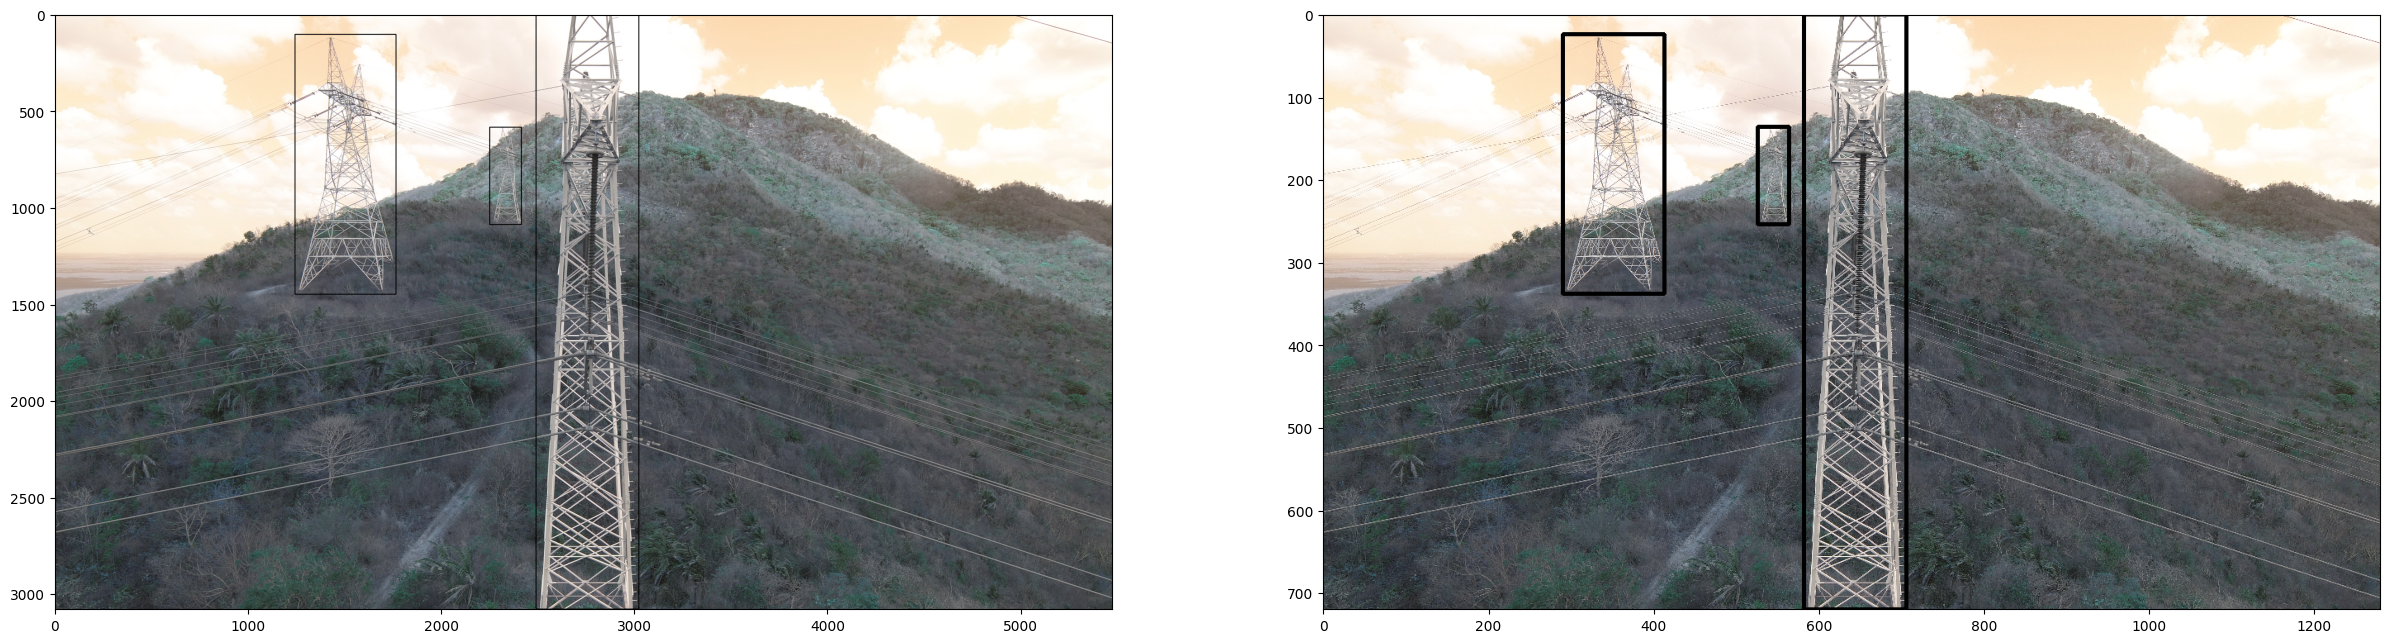

In [46]:
import matplotlib.pyplot as plt

def objectPlot(img):
    with open('./DATA/train/labels/DJI_0412.txt') as f:
        lines = f.readlines() 
        for line in lines:
      
                # Получим высоту и ширину изображения
                h, w, _ = img.shape   
                        
                # Получаем координаты объекта
                x_start, y_start, x_end, y_end = converterYOLOToCV2(
                    h, w,
                    [float(item) for item in line.split()[1:]] 
                )
                    
                # Отрисуем границы объекта на изображение
                img = cv2.rectangle(
                    img=img, 
                    pt1=(x_start, y_start), 
                    pt2=(x_end, y_end), 
                    color=(0, 0, 0), 
                    thickness=4
                )
fig, axes = plt.subplots(1, 2, figsize=(30,15))
img = cv2.imread('./DATASET/STN/20181127-A1/DJI_0412.JPG', cv2.IMREAD_UNCHANGED)
img_new = cv2.resize(img, (1280, 720), cv2.INTER_NEAREST)
objectPlot(img)
objectPlot(img_new)
axes[0].imshow(img)
axes[1].imshow(img_new)
plt.savefig('test.png')